In [2]:

import pandas as pd

import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv('./.data/data.csv')

data = data.rename(columns={
    'Aika': 'Aika',  # Keep the same
    'Hinta (snt/kWh)': 'Hinta_snt_per_kWh',
    'Keskituulen nopeus [m/s]': 'Keskituulen_nopeus_m_per_s',
    'Lämpötilan keskiarvo [°C]': 'Lampotilan_keskiarvo_C',
    'Kulutus (kWh/h)': 'Kulutus_kWh_per_h',
    'Tuotanto (kW)': 'Tuotanto_kW',
    'is_holiday': 'is_holiday'  
})

data.shape

(32432, 7)

In [7]:
data

,Aika,Hinta_snt_per_kWh,Keskituulen_nopeus_m_per_s,Lampotilan_keskiarvo_C,Kulutus_kWh_per_h,Tuotanto_kW,is_holiday
0,2021-01-01 01:00:00,3.094,5.6,0.8,9206000.0,6.830650e+06,1
1,2021-01-01 02:00:00,3.019,4.8,0.7,9042000.0,6.853130e+06,1
2,2021-01-01 03:00:00,2.974,5.0,0.5,9010000.0,6.822395e+06,1
3,2021-01-01 04:00:00,2.941,4.6,0.4,9057000.0,6.912865e+06,1
4,2021-01-01 05:00:00,2.943,4.9,0.4,9219000.0,7.054030e+06,1
...,...,...,...,...,...,...,...
32427,2024-09-21 12:00:00,0.387,11.8,10.0,8062210.0,8.725515e+06,0
32428,2024-09-21 13:00:00,0.001,11.1,10.1,8202330.0,8.923810e+06,0
32429,2024-09-21 15:00:00,0.242,11.1,10.8,8498940.0,8.412320e+06,0
32430,2024-09-21 16:00:00,0.695,11.0,11.2,8282280.0,8.506920e+06,0


In [8]:
data.describe()

,Hinta_snt_per_kWh,Keskituulen_nopeus_m_per_s,Lampotilan_keskiarvo_C,Kulutus_kWh_per_h,Tuotanto_kW,is_holiday
count,32432.000000,32432.000000,32432.000000,3.243200e+04,3.243200e+04,32432.000000
mean,10.407546,6.625771,4.625648,9.244002e+06,8.162133e+06,0.034657
std,11.912487,3.193132,8.645704,1.604496e+06,1.589415e+06,0.182913
min,-6.004000,0.400000,-20.000000,5.675000e+06,4.159655e+06,0.000000
25%,2.995000,4.300000,-1.500000,8.035000e+06,7.030019e+06,0.000000
50%,6.870500,6.300000,2.700000,8.942000e+06,8.040290e+06,0.000000
75%,13.080250,8.600000,12.500000,1.034325e+07,9.127366e+06,0.000000
max,235.104000,22.200000,25.800000,1.496300e+07,1.424490e+07,1.000000


## XGBoost Model

In [26]:
from xgboost import XGBRegressor

# Split data



train_ratio = 0.7 # 70%
val_ratio = 0.2 # 20%

print("Splitting ")
n = len(data)
train_end = int(n * train_ratio)
val_end = train_end + int(n * val_ratio)

train_df = data.iloc[:train_end]
val_df = data.iloc[train_end:val_end]
test_df = data.iloc[val_end:]

print(f"Sequential split complete. Train shape: {train_df.shape}, Val shape: {val_df.shape}, Test shape: {test_df.shape}")

Splitting 
Sequential split complete. Train shape: (22702, 7), Val shape: (6486, 7), Test shape: (3244, 7)


In [27]:
train_df.columns

Index(['Aika', 'Hinta_snt_per_kWh', 'Keskituulen_nopeus_m_per_s',
       'Lampotilan_keskiarvo_C', 'Kulutus_kWh_per_h', 'Tuotanto_kW',
       'is_holiday'],
      dtype='object')

In [28]:
columns_to_drop = ['Aika','Hinta_snt_per_kWh']
target_col = 'Hinta_snt_per_kWh'

X_train = train_df.drop(columns=columns_to_drop)
X_val = val_df.drop(columns=columns_to_drop)
X_test = test_df.drop(columns=columns_to_drop)
y_train = train_df[target_col]
y_val = val_df[target_col]
y_test = test_df[target_col]

X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

In [29]:
print("Training model...")
model = XGBRegressor()
model.fit(X_train_val, y_train_val, verbose=False)
joblib.dump(model, './.model/xgboost/xgboost_model.pkl')

Training model...


['./.model/xgboost/xgboost_model.pkl']

In [30]:
y_pred = model.predict(X_test)

print("Evaluating model performance...")
mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred)
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE (Mean Absolute Error) on Test Set: {mae_test:.2f}")
print(f"MSE (Mean Squared Error) on Test Set: {mse_test:.2f}")
print(f"RMSE (Root Mean Squared Error) on Test Set: {rmse_test:.2f}")
print(f"R² (Coefficient of Determination) on Test Set: {r2_test:.2f}")
print(f"MAPE (Mean Absolute Percentage Error) on Test Set: {mape_test:.2f}%")

Evaluating model performance...
MAE (Mean Absolute Error) on Test Set: 8.87
MSE (Mean Squared Error) on Test Set: 164.41
RMSE (Root Mean Squared Error) on Test Set: 12.82
R² (Coefficient of Determination) on Test Set: -4.47
MAPE (Mean Absolute Percentage Error) on Test Set: inf%


In [31]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, 'g-', label='The real value', linewidth=2)
plt.plot(test_df.index, y_pred, 'r--', label='The predicted value', linewidth=2)
plt.title(f'XGBOOST Real vs Predicted', fontsize=16)
plt.xlabel('Data Point', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('./.model/xgboost/real_predicted_plot.png')
plt.close()


## Random Forest

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

data = data.drop(columns='Aika')
target = 'Hinta_snt_per_kWh'

X = data.drop(columns=target)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20, random_state=42)

from sklearn.preprocessing import StandardScaler

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [10]:
# Train a Random Forest Regressor
model = RandomForestRegressor(bootstrap=False, max_features=0.45, min_samples_leaf=3, min_samples_split=8, n_estimators=100) # Found using TPOT
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 89.65198512599345


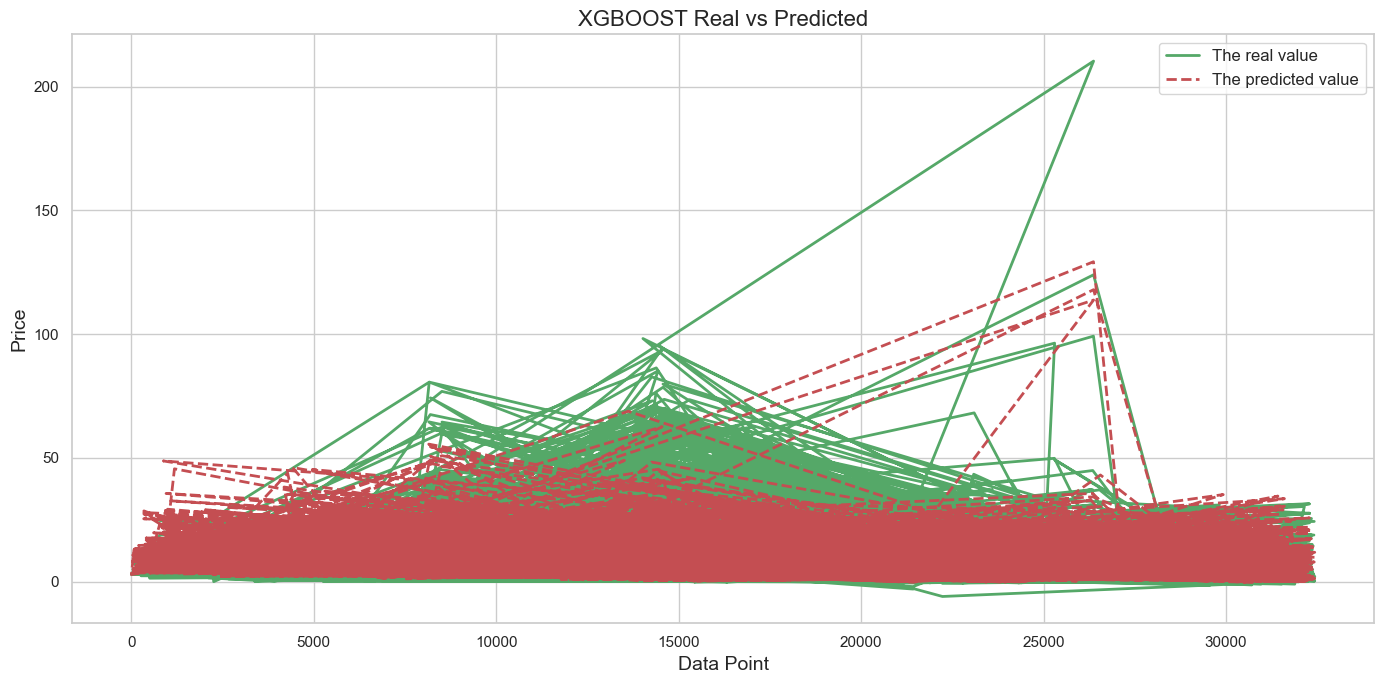

In [12]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, 'g-', label='The real value', linewidth=2)
plt.plot(y_test.index, y_pred, 'r--', label='The predicted value', linewidth=2)
plt.title(f'Random Forest Real vs Predicted', fontsize=16)
plt.xlabel('Data Point', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig('./.model/rf/real_predicted_plot.png')
plt.close()


In [15]:
import plotly.express as px

px.scatter(x=y_test.index, y=[y_test,y_pred])
#px.line(x=y_test.index, y=y_pred)